<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [1]:
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='summer')

In [2]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.3
    Uninstalling accelerate-0.29.3:
      Successfully uninstalled accelerate-0.29.3


In [3]:
!pip install transformers

In [4]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [5]:
!pip install datasets
None

In [6]:
import transformers
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split

2024-05-30 14:34:07.053638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 14:34:07.053761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 14:34:07.179184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str, n_classes : int=2):
        #temp_model = transformers.AutoModel.from_pretrained(base_transformer_model)
        #del temp_model.pooler
        super().__init__()
        self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model, output_attentions=True)
        #self.tokenizer= transformers.AutoTokenizer.from_pretrained(base_transformer_model)
        # YOUR CODE: create additional layers for classfication
        self.drop = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.backbone.config.hidden_size, n_classes) # in 312 for ruberty-tiny

    def forward(self, inputs, attention_mask):
        # YOUR CODE: propagate inputs through the model. Return dict with logits
        pooled_output = self.backbone(
            input_ids=inputs,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        logits = self.linear(output)
        return logits

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [9]:
def freeze_backbone_function(model: TransformerClassificationModel):
  for name, param in model.named_parameters():
     if name.startswith("backbone"):
        param.requires_grad = False

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [10]:
import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup

def train_transformer(model, train_dataloader,
                      val_dataloader, num_epochs=10,
                      learning_rate=1e-4, warmup_steps=500, freeze_backbone=False, draw=True):
    if freeze_backbone:
      freeze_backbone_function(model)
    
    criterion = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Training Loop
        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
        for batch in train_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            
            logits = model(input_ids, attention_mask=attention_masks)
            loss = criterion(logits, labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_progress_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_progress_bar = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
        with torch.no_grad():
            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_masks = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask=attention_masks)
                loss = criterion(logits, labels)

                val_loss += loss.item()
                
                predictions = torch.argmax(logits, dim=1)
                val_correct += torch.sum(predictions == labels).item()
                val_total += labels.size(0)

                val_progress_bar.set_postfix(loss=loss.item(), accuracy=(val_correct / val_total))

        val_loss /= len(val_dataloader)
        val_accuracy = val_correct / val_total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    print("Training Summary:")
    for epoch, (train_loss, val_loss, val_accuracy) in enumerate(zip(train_losses, val_losses, val_accuracies)):
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    if draw:
        plt.figure(figsize=(10, 7))
        plt.plot(train_losses, label='train loss')
        plt.plot(val_losses, label='validation loss')

        plt.title('Training history')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
        plt.plot(val_accuracies, label='validation acc')
        plt.title('Accuracy')
        plt.show()

    return model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [11]:
df = pd.read_csv('/kaggle/input/dls-math-classification-7/data_problems.xlsx - Sheet1.csv')

In [12]:
X, y = df['Задача'], df['Тема']
y = pd.get_dummies(y).astype(int)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [14]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, shuffle=True, random_state=42)

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class TransformerDataset(Dataset):
    def __init__(self, x, y, tokenizer, max_length):
        self.data = pd.concat([x, y], axis=1)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [16]:
batch_size = 32
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

train_dataset = TransformerDataset(X_train, y_train, tokenizer=tokenizer, max_length=512)
val_dataset = TransformerDataset(X_val, y_val, tokenizer=tokenizer, max_length=512)
test_dataset = TransformerDataset(X_test, y_test, tokenizer=tokenizer, max_length=512)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Epoch [1/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.46it/s, accuracy=0.454, loss=1.88]


Epoch [1/10], Train Loss: 1.9075, Val Loss: 1.8852, Val Accuracy: 0.4540


Epoch [2/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.34it/s, accuracy=0.779, loss=1.76]


Epoch [2/10], Train Loss: 1.8321, Val Loss: 1.7741, Val Accuracy: 0.7795


Epoch [3/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.56it/s, accuracy=0.875, loss=1.59]


Epoch [3/10], Train Loss: 1.6827, Val Loss: 1.6010, Val Accuracy: 0.8750


Epoch [4/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.59it/s, accuracy=0.909, loss=1.38]


Epoch [4/10], Train Loss: 1.4794, Val Loss: 1.3871, Val Accuracy: 0.9095


Epoch [5/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.65it/s, accuracy=0.914, loss=1.18]


Epoch [5/10], Train Loss: 1.2539, Val Loss: 1.1730, Val Accuracy: 0.9138


Epoch [6/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.65it/s, accuracy=0.915, loss=1.04]


Epoch [6/10], Train Loss: 1.0630, Val Loss: 1.0254, Val Accuracy: 0.9145


Epoch [7/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.43it/s, accuracy=0.917, loss=0.951]


Epoch [7/10], Train Loss: 0.9412, Val Loss: 0.9307, Val Accuracy: 0.9174


Epoch [8/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.66it/s, accuracy=0.919, loss=0.897]


Epoch [8/10], Train Loss: 0.8633, Val Loss: 0.8717, Val Accuracy: 0.9188


Epoch [9/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.62it/s, accuracy=0.919, loss=0.868]


Epoch [9/10], Train Loss: 0.8187, Val Loss: 0.8389, Val Accuracy: 0.9188


Epoch [10/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.51it/s, accuracy=0.919, loss=0.858]


Epoch [10/10], Train Loss: 0.7956, Val Loss: 0.8281, Val Accuracy: 0.9188
Training Summary:
Epoch [1/10], Train Loss: 1.9075, Val Loss: 1.8852, Val Accuracy: 0.4540
Epoch [2/10], Train Loss: 1.8321, Val Loss: 1.7741, Val Accuracy: 0.7795
Epoch [3/10], Train Loss: 1.6827, Val Loss: 1.6010, Val Accuracy: 0.8750
Epoch [4/10], Train Loss: 1.4794, Val Loss: 1.3871, Val Accuracy: 0.9095
Epoch [5/10], Train Loss: 1.2539, Val Loss: 1.1730, Val Accuracy: 0.9138
Epoch [6/10], Train Loss: 1.0630, Val Loss: 1.0254, Val Accuracy: 0.9145
Epoch [7/10], Train Loss: 0.9412, Val Loss: 0.9307, Val Accuracy: 0.9174
Epoch [8/10], Train Loss: 0.8633, Val Loss: 0.8717, Val Accuracy: 0.9188
Epoch [9/10], Train Loss: 0.8187, Val Loss: 0.8389, Val Accuracy: 0.9188
Epoch [10/10], Train Loss: 0.7956, Val Loss: 0.8281, Val Accuracy: 0.9188


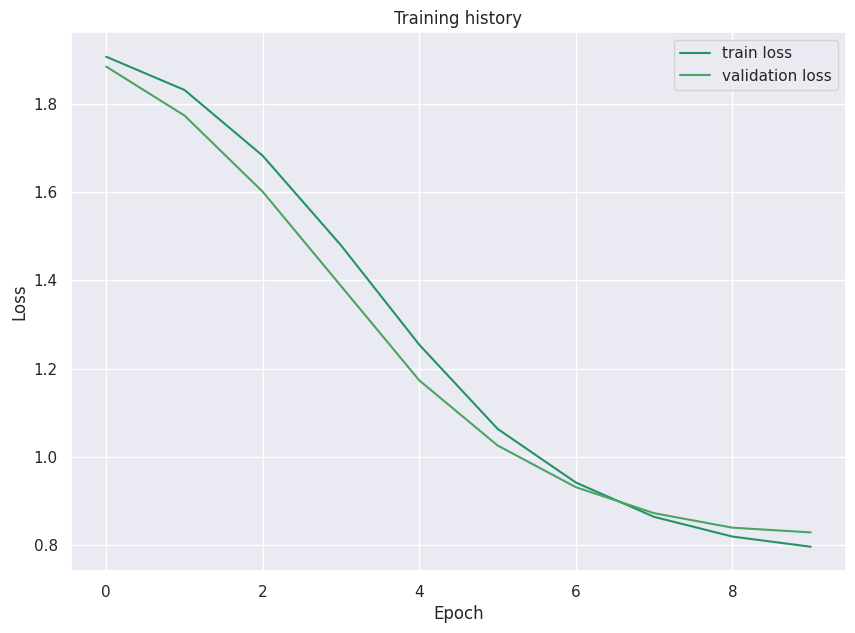

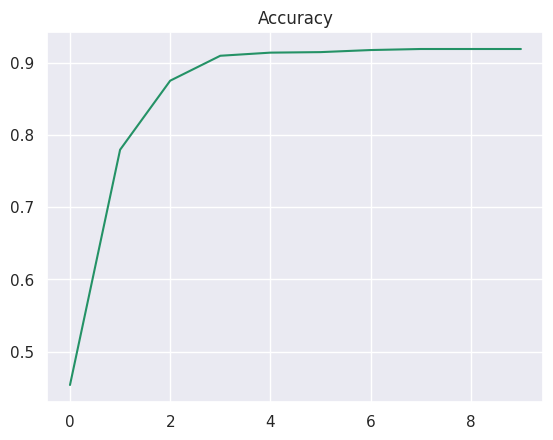

Epoch [1/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.53it/s, accuracy=0.923, loss=0.593]


Epoch [1/10], Train Loss: 1.2963, Val Loss: 0.3648, Val Accuracy: 0.9231


Epoch [2/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.64it/s, accuracy=0.984, loss=0.0663]


Epoch [2/10], Train Loss: 0.1838, Val Loss: 0.0855, Val Accuracy: 0.9842


Epoch [3/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.60it/s, accuracy=0.991, loss=0.0189]


Epoch [3/10], Train Loss: 0.0491, Val Loss: 0.0437, Val Accuracy: 0.9907


Epoch [4/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.59it/s, accuracy=0.991, loss=0.0078]


Epoch [4/10], Train Loss: 0.0253, Val Loss: 0.0351, Val Accuracy: 0.9914


Epoch [5/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.52it/s, accuracy=0.992, loss=0.00527]


Epoch [5/10], Train Loss: 0.0194, Val Loss: 0.0282, Val Accuracy: 0.9921


Epoch [6/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.55it/s, accuracy=0.992, loss=0.00317]


Epoch [6/10], Train Loss: 0.0098, Val Loss: 0.0364, Val Accuracy: 0.9921


Epoch [7/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.54it/s, accuracy=0.993, loss=0.00269]


Epoch [7/10], Train Loss: 0.0058, Val Loss: 0.0343, Val Accuracy: 0.9928


Epoch [8/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.64it/s, accuracy=0.993, loss=0.00213]


Epoch [8/10], Train Loss: 0.0054, Val Loss: 0.0327, Val Accuracy: 0.9928


Epoch [9/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.55it/s, accuracy=0.994, loss=0.00189]


Epoch [9/10], Train Loss: 0.0043, Val Loss: 0.0325, Val Accuracy: 0.9943


Epoch [10/10] Validation: 100%|██████████| 44/44 [00:03<00:00, 12.58it/s, accuracy=0.994, loss=0.00186]


Epoch [10/10], Train Loss: 0.0038, Val Loss: 0.0334, Val Accuracy: 0.9935
Training Summary:
Epoch [1/10], Train Loss: 1.2963, Val Loss: 0.3648, Val Accuracy: 0.9231
Epoch [2/10], Train Loss: 0.1838, Val Loss: 0.0855, Val Accuracy: 0.9842
Epoch [3/10], Train Loss: 0.0491, Val Loss: 0.0437, Val Accuracy: 0.9907
Epoch [4/10], Train Loss: 0.0253, Val Loss: 0.0351, Val Accuracy: 0.9914
Epoch [5/10], Train Loss: 0.0194, Val Loss: 0.0282, Val Accuracy: 0.9921
Epoch [6/10], Train Loss: 0.0098, Val Loss: 0.0364, Val Accuracy: 0.9921
Epoch [7/10], Train Loss: 0.0058, Val Loss: 0.0343, Val Accuracy: 0.9928
Epoch [8/10], Train Loss: 0.0054, Val Loss: 0.0327, Val Accuracy: 0.9928
Epoch [9/10], Train Loss: 0.0043, Val Loss: 0.0325, Val Accuracy: 0.9943
Epoch [10/10], Train Loss: 0.0038, Val Loss: 0.0334, Val Accuracy: 0.9935


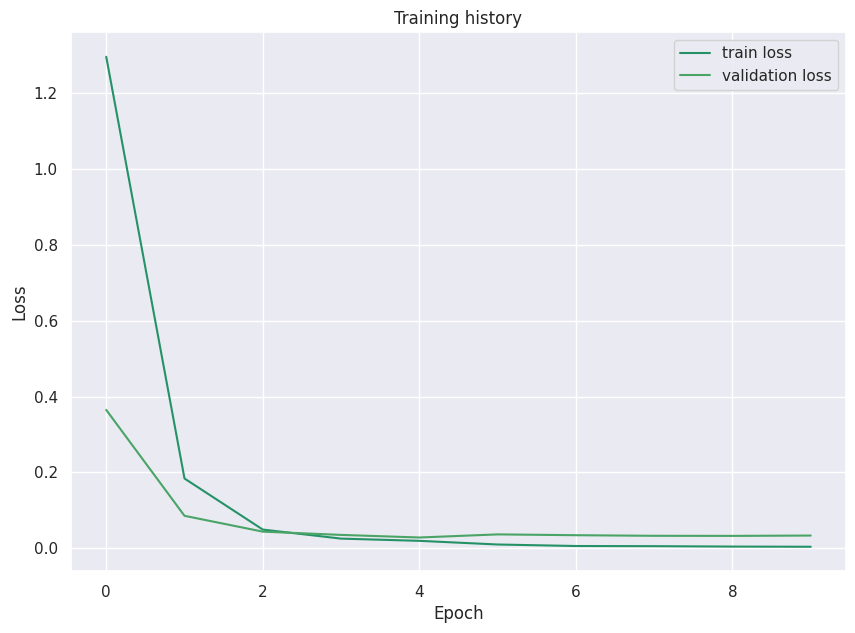

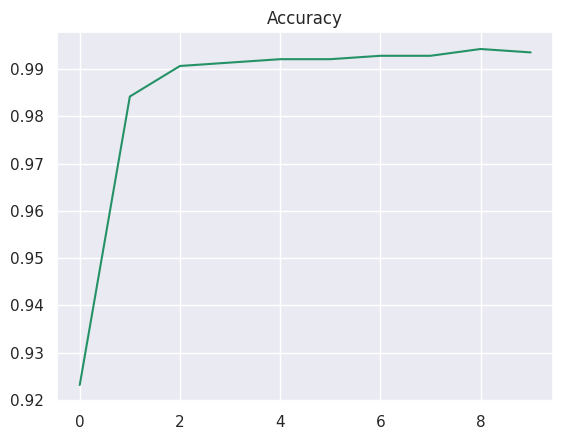

In [17]:
rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2", n_classes = 7)
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model,
                                                                train_dataloader=train_loader,
                                                                val_dataloader=val_loader, freeze_backbone=True)

rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2", n_classes = 7)
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model,
                                               train_dataloader=train_loader,
                                               val_dataloader=val_loader, freeze_backbone=False)

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [18]:
batch_size = 16
tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBERT")

train_dataset = TransformerDataset(X_train, y_train, tokenizer=tokenizer, max_length=512)
val_dataset = TransformerDataset(X_val, y_val, tokenizer=tokenizer, max_length=512)
test_dataset = TransformerDataset(X_test, y_test, tokenizer=tokenizer, max_length=512)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Epoch [1/5] Validation: 100%|██████████| 87/87 [00:25<00:00,  3.35it/s, accuracy=0.97, loss=0.18]


Epoch [1/5], Train Loss: 0.2962, Val Loss: 0.1112, Val Accuracy: 0.9698


Epoch [2/5] Validation: 100%|██████████| 87/87 [00:25<00:00,  3.36it/s, accuracy=0.977, loss=0.041]


Epoch [2/5], Train Loss: 0.0999, Val Loss: 0.0807, Val Accuracy: 0.9770


Epoch [3/5] Validation: 100%|██████████| 87/87 [00:25<00:00,  3.35it/s, accuracy=0.982, loss=0.0132]


Epoch [3/5], Train Loss: 0.0745, Val Loss: 0.0618, Val Accuracy: 0.9820


Epoch [4/5] Validation: 100%|██████████| 87/87 [00:25<00:00,  3.35it/s, accuracy=0.988, loss=0.0143]


Epoch [4/5], Train Loss: 0.0344, Val Loss: 0.0445, Val Accuracy: 0.9878


Epoch [5/5] Validation: 100%|██████████| 87/87 [00:25<00:00,  3.35it/s, accuracy=0.989, loss=0.00209]


Epoch [5/5], Train Loss: 0.0168, Val Loss: 0.0449, Val Accuracy: 0.9885
Training Summary:
Epoch [1/5], Train Loss: 0.2962, Val Loss: 0.1112, Val Accuracy: 0.9698
Epoch [2/5], Train Loss: 0.0999, Val Loss: 0.0807, Val Accuracy: 0.9770
Epoch [3/5], Train Loss: 0.0745, Val Loss: 0.0618, Val Accuracy: 0.9820
Epoch [4/5], Train Loss: 0.0344, Val Loss: 0.0445, Val Accuracy: 0.9878
Epoch [5/5], Train Loss: 0.0168, Val Loss: 0.0449, Val Accuracy: 0.9885


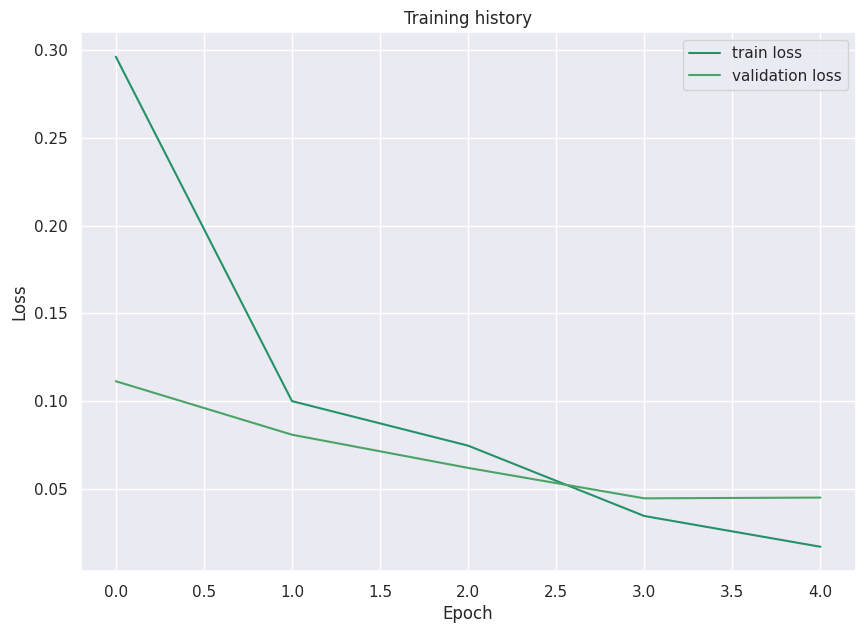

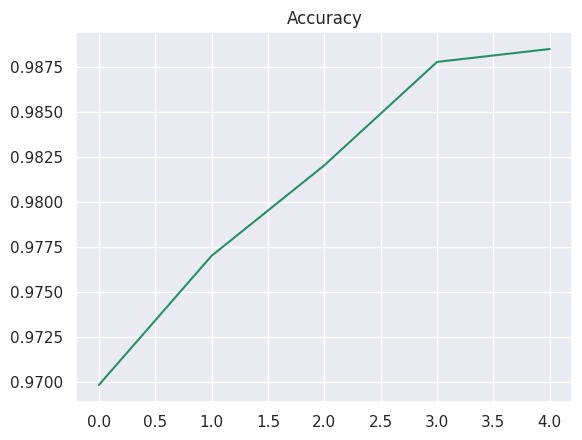

In [19]:
mathbert_transformer_model = TransformerClassificationModel("tbs17/MathBERT", n_classes = 7)
mathbert_full_finetuned = train_transformer(mathbert_transformer_model,
                                            train_dataloader=train_loader,
                                            val_dataloader=val_loader,
                                            num_epochs=5, freeze_backbone=False)

В целом, accuracy хуже. Я бы связал это с токенизатором, который некорректно работает с русским языком, что демонстрируют следующие ячейки:

In [20]:
text1 = "Какой завтра день?"
text2 = "Doesn`t matter at all"
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
t_out1 = tokenizer(text1, return_tensors='pt')
input_ids = t_out1['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids[0]))
t_out2 = tokenizer(text2, return_tensors='pt')
input_ids = t_out2['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids[0]))

['[CLS]', 'Какой', 'завтра', 'день', '?', '[SEP]']
['[CLS]', 'Does', '##n', '[UNK]', 't', 'matter', 'at', 'all', '[SEP]']


In [21]:
tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBERT")
t_out1 = tokenizer(text1, return_tensors='pt')
input_ids = t_out1['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids[0]))
t_out2 = tokenizer(text2, return_tensors='pt')
input_ids = t_out2['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids[0]))

['[CLS]', 'к', '##а', '##к', '##о', '##и', 'з', '##а', '##в', '##т', '##р', '##а', 'д', '##е', '##н', '##ь', '?', '[SEP]']
['[CLS]', 'doesn', '`', 't', 'matter', 'at', 'all', '[SEP]']


### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [22]:
def draw_first_layer_attention_maps(attention_head_ids, tokenizer, text, model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        out = model.backbone(input_ids, attention_mask)
        pooler_output = out.pooler_output
        last_hidden_states = out.last_hidden_state
        attentions = out.attentions
    
    # Get the attention weights from the first layer
    first_layer_attentions = attentions[0]  # Shape: [batch_size, num_heads, seq_len, seq_len]

    # Get tokenized words
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Determine the grid size for subplots
    num_heads = len(attention_head_ids)
    grid_size = int(np.ceil(np.sqrt(num_heads)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(5 * grid_size, 5 * grid_size))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Iterate through specified attention heads and plot the attention weights
    for idx, head_id in enumerate(attention_head_ids):
        # Extract the attention weights for the specified head
        attention_weights = first_layer_attentions[0, head_id].cpu().detach().numpy()

        # Plot the attention weights
        sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap='viridis', ax=axes[idx])
        axes[idx].set_title(f'Attention Map for Head {head_id}')
        axes[idx].set_xlabel('Tokens')
        axes[idx].set_ylabel('Tokens')
    
    # Hide any unused subplots
    for idx in range(num_heads, grid_size * grid_size):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

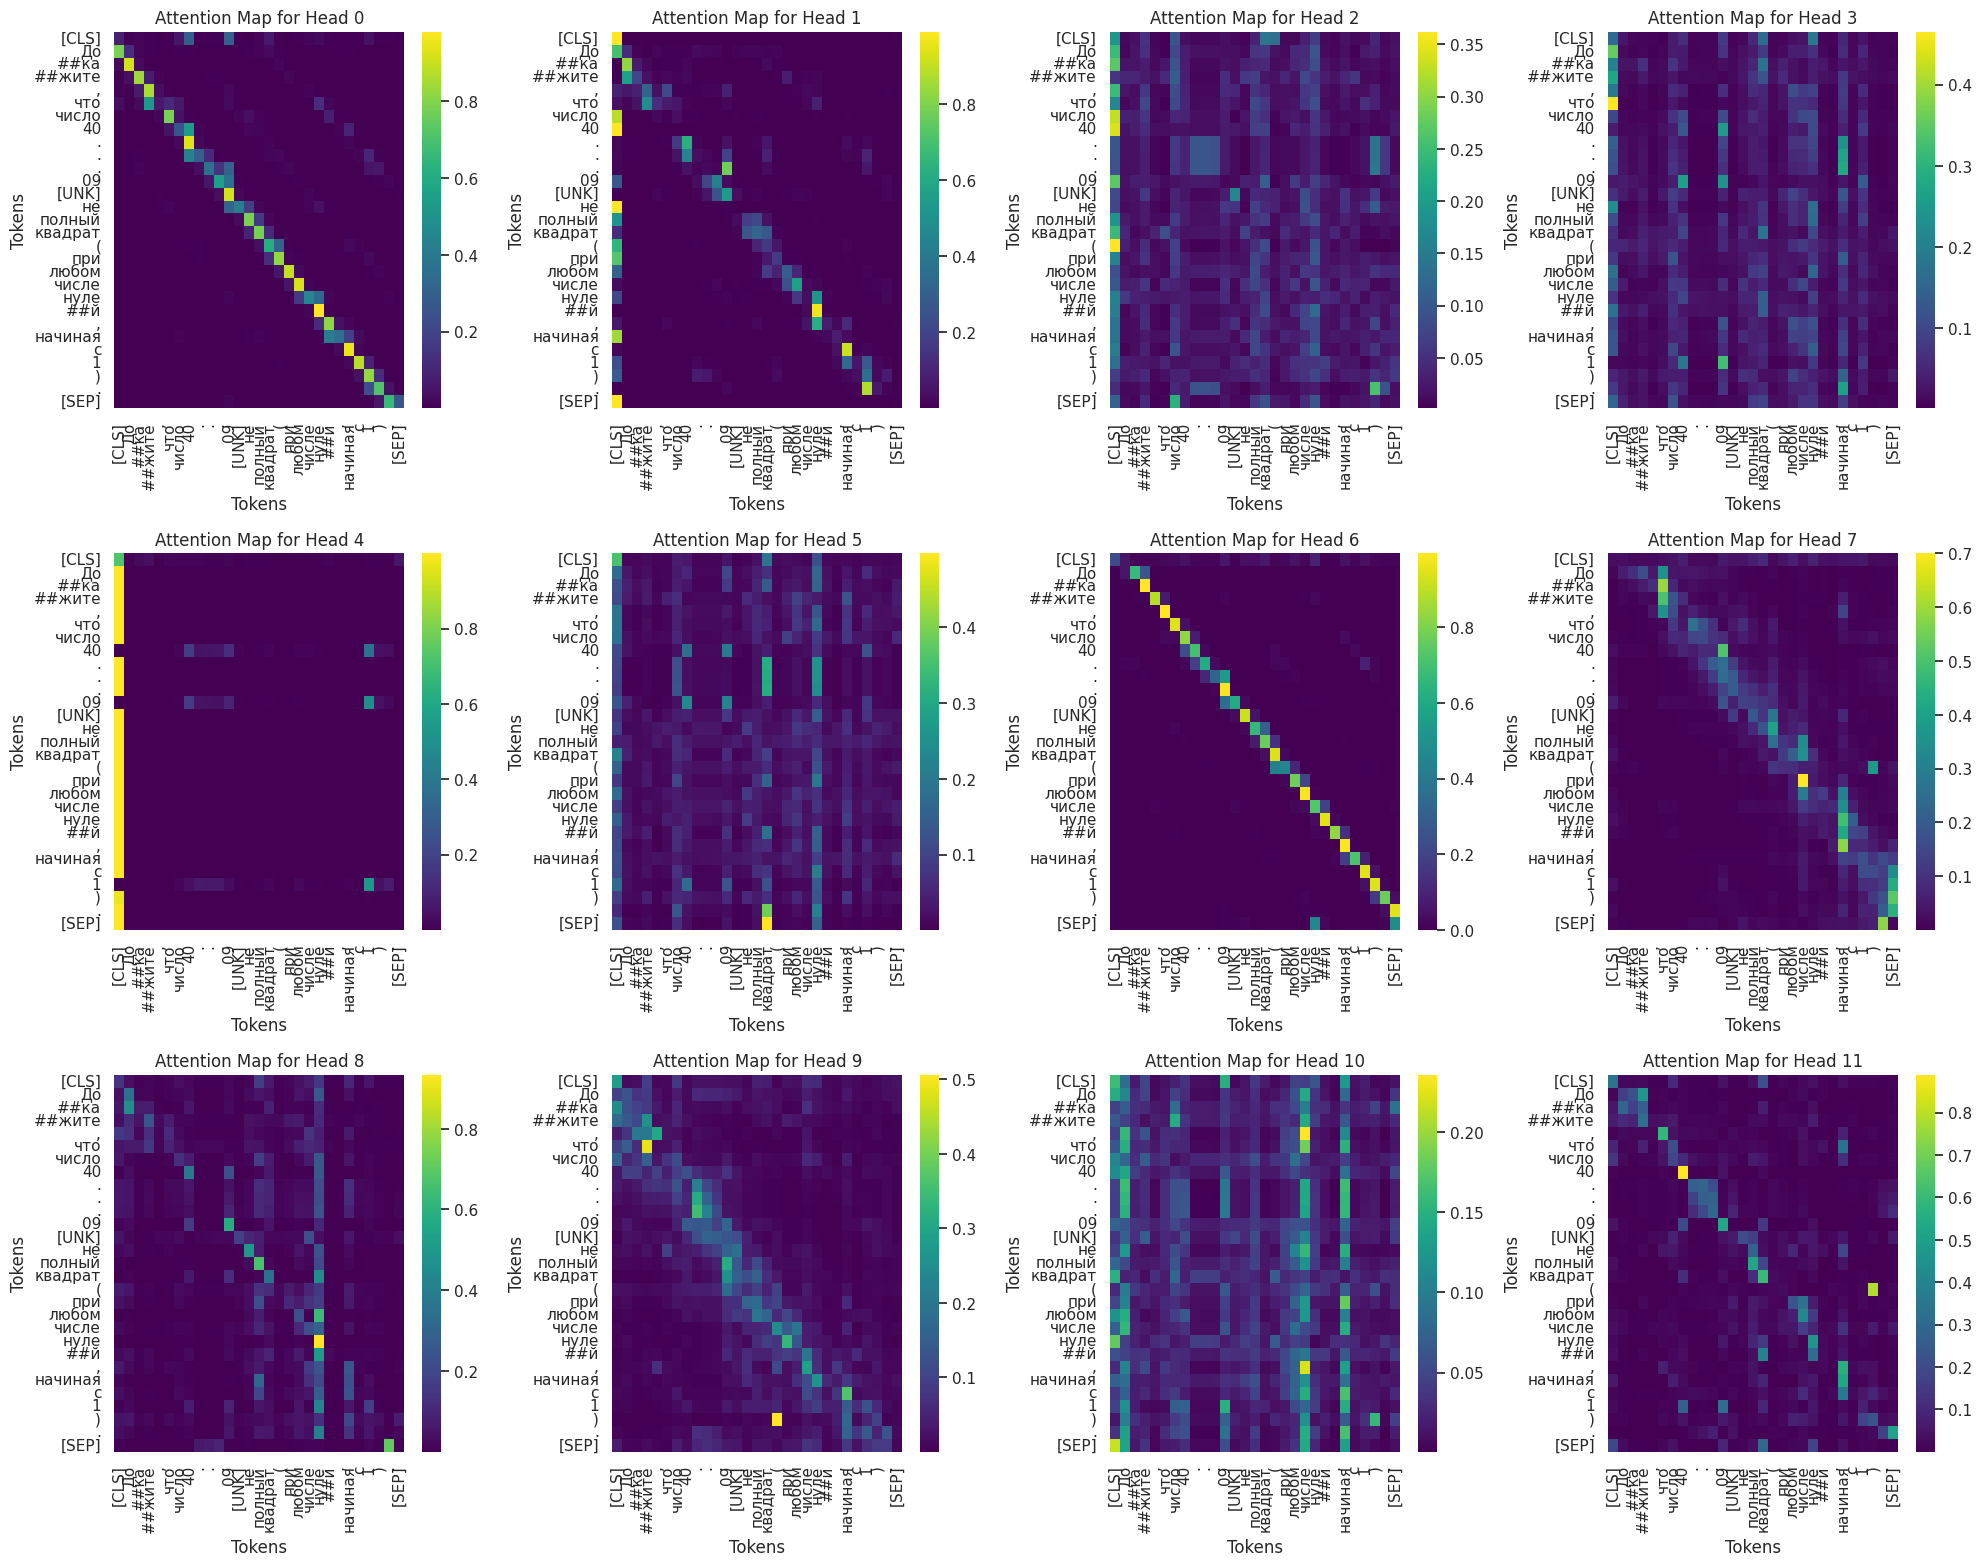

Геометрия        0
Графы            0
Дирихле          0
Инвариант        0
Комбинаторика    0
Многочлен        0
Теория чисел     1
Name: 4172, dtype: int64


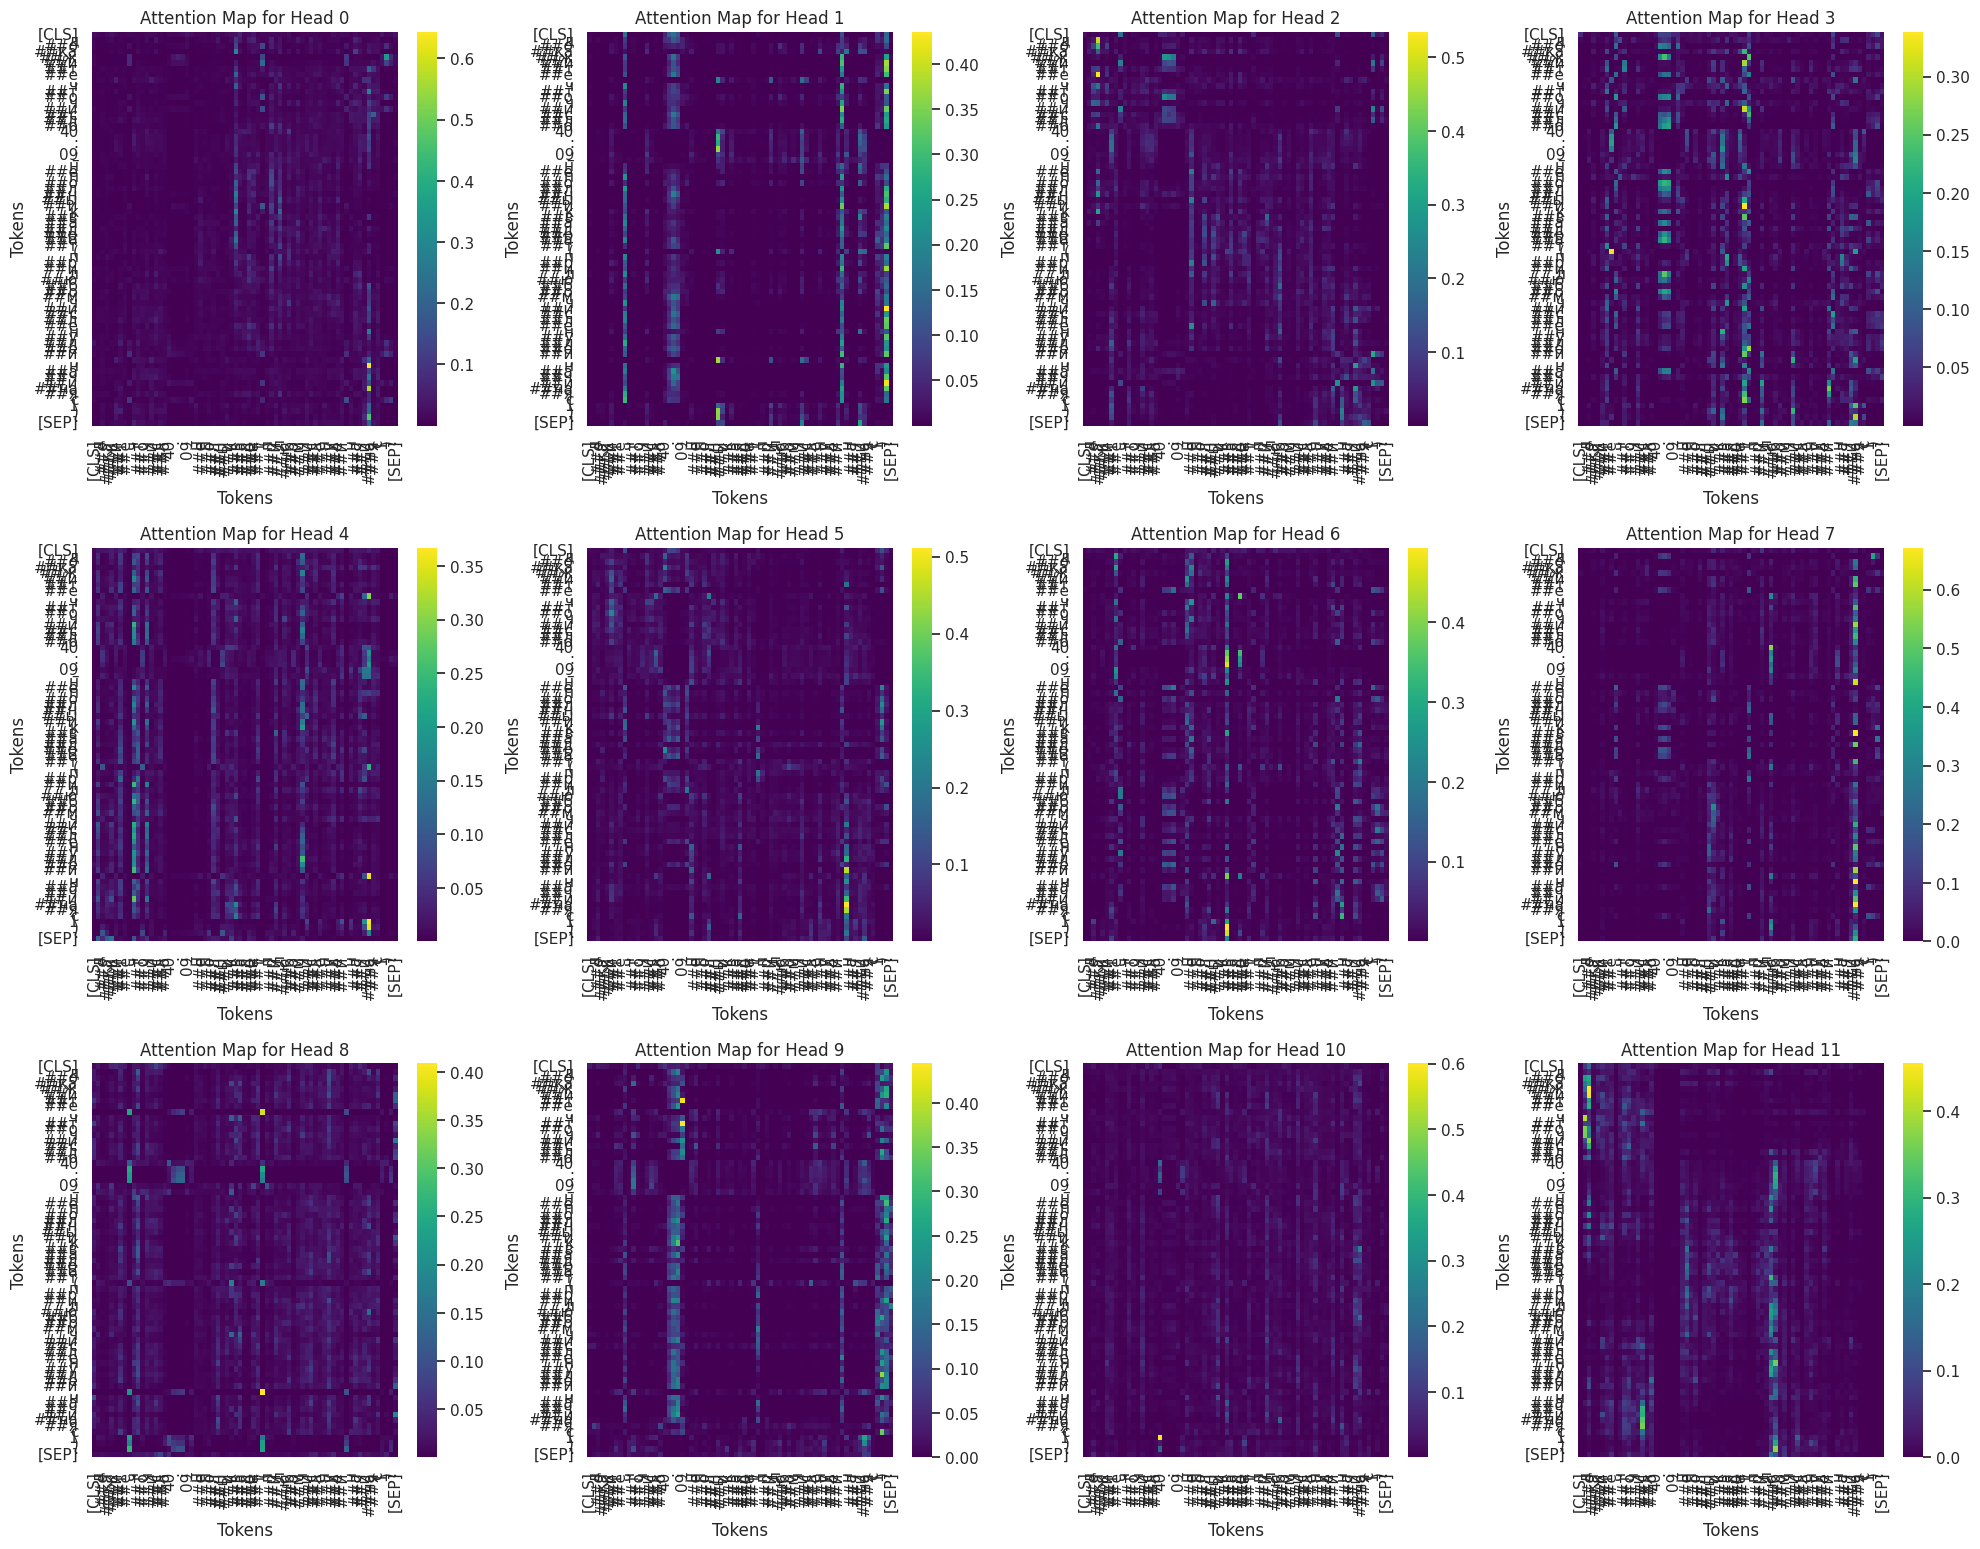

Геометрия        0
Графы            0
Дирихле          0
Инвариант        0
Комбинаторика    0
Многочлен        0
Теория чисел     1
Name: 4172, dtype: int64


In [23]:
# text = "find all solutions of the equation z=x+y^2"
names = ["cointegrated/rubert-tiny2", "tbs17/MathBERT"]
for name in names:
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = TransformerClassificationModel(name, n_classes = 7).to(device)
    sample_text = X_test.iloc[256]
    sample_label = y_test.iloc[256]
    
    attention_head_ids = list(range(12))
    draw_first_layer_attention_maps(attention_head_ids, tokenizer, sample_text, model)
    print(sample_label)

Сложно что-то сказать на примерах из датасета из-за их длины. Но, например головы 1 и 9 модели rubert улавливают связи слов вроде "докажите что", "начиная с"

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Epoch [1/5] Validation: 100%|██████████| 87/87 [00:03<00:00, 21.85it/s, accuracy=0.923, loss=0.573]


Epoch [1/5], Train Loss: 0.7463, Val Loss: 0.2965, Val Accuracy: 0.9231


Epoch [2/5] Validation: 100%|██████████| 87/87 [00:03<00:00, 21.84it/s, accuracy=0.987, loss=0.0226]


Epoch [2/5], Train Loss: 0.1652, Val Loss: 0.0591, Val Accuracy: 0.9871


Epoch [3/5] Validation: 100%|██████████| 87/87 [00:03<00:00, 21.85it/s, accuracy=0.985, loss=0.0128]


Epoch [3/5], Train Loss: 0.0509, Val Loss: 0.0522, Val Accuracy: 0.9849


Epoch [4/5] Validation: 100%|██████████| 87/87 [00:03<00:00, 21.76it/s, accuracy=0.989, loss=0.00446]


Epoch [4/5], Train Loss: 0.0267, Val Loss: 0.0516, Val Accuracy: 0.9885


Epoch [5/5] Validation: 100%|██████████| 87/87 [00:04<00:00, 21.59it/s, accuracy=0.987, loss=0.00466]


Epoch [5/5], Train Loss: 0.0146, Val Loss: 0.0527, Val Accuracy: 0.9871
Training Summary:
Epoch [1/5], Train Loss: 0.7463, Val Loss: 0.2965, Val Accuracy: 0.9231
Epoch [2/5], Train Loss: 0.1652, Val Loss: 0.0591, Val Accuracy: 0.9871
Epoch [3/5], Train Loss: 0.0509, Val Loss: 0.0522, Val Accuracy: 0.9849
Epoch [4/5], Train Loss: 0.0267, Val Loss: 0.0516, Val Accuracy: 0.9885
Epoch [5/5], Train Loss: 0.0146, Val Loss: 0.0527, Val Accuracy: 0.9871


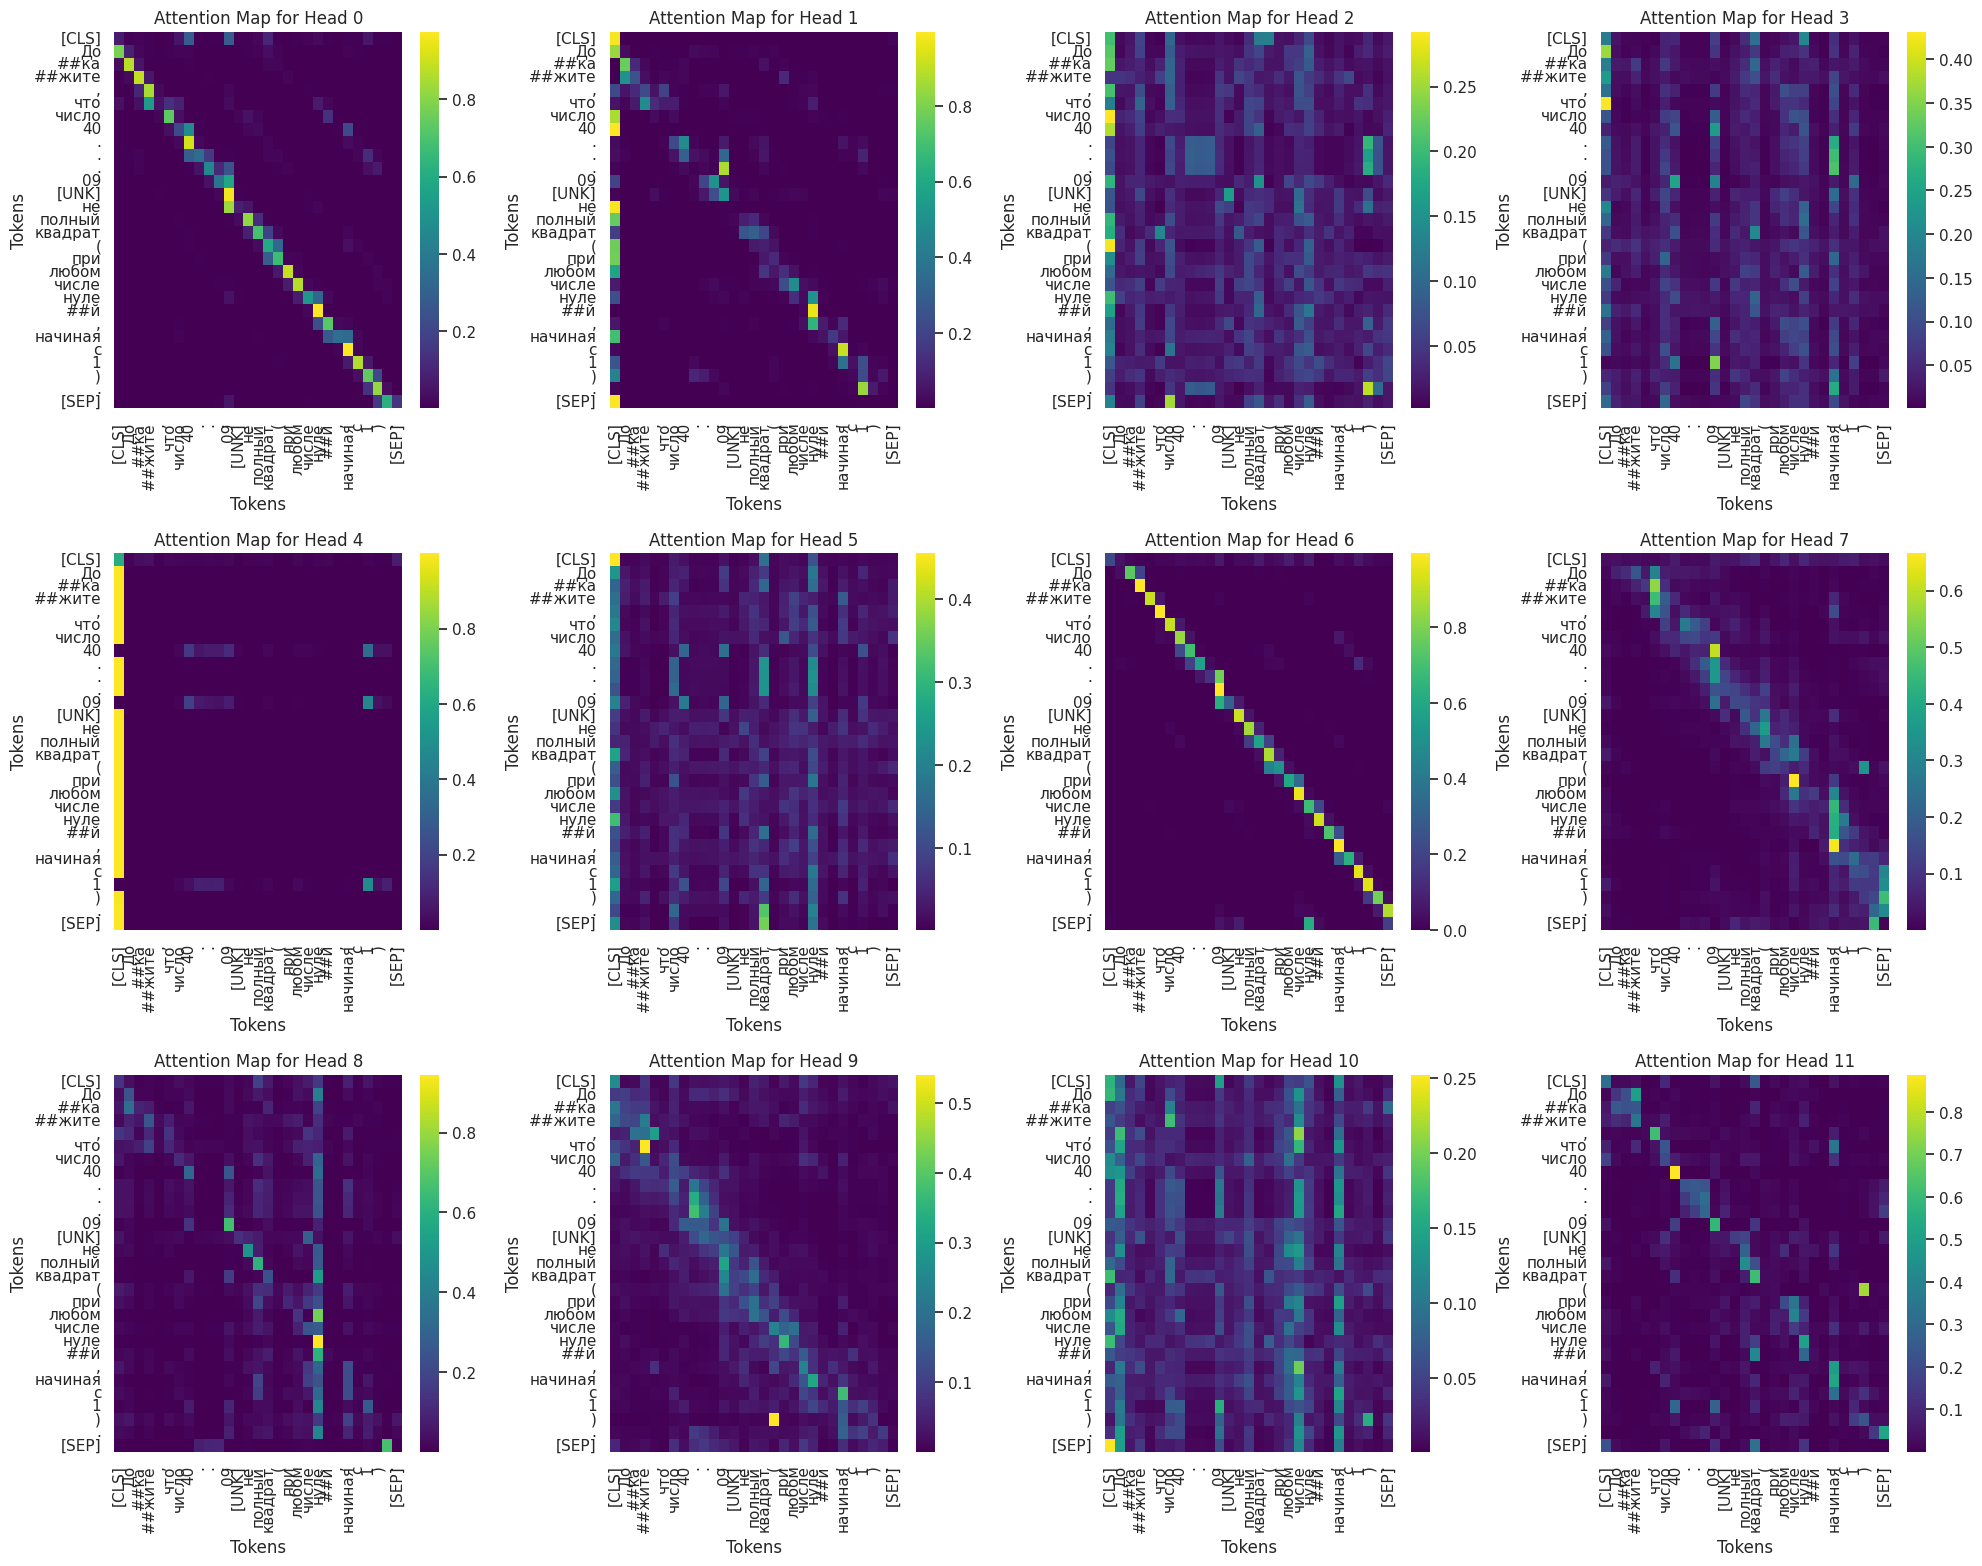

Геометрия        0
Графы            0
Дирихле          0
Инвариант        0
Комбинаторика    0
Многочлен        0
Теория чисел     1
Name: 4172, dtype: int64


Epoch [1/5] Validation: 100%|██████████| 87/87 [00:26<00:00,  3.34it/s, accuracy=0.98, loss=0.0556]


Epoch [1/5], Train Loss: 0.3703, Val Loss: 0.0680, Val Accuracy: 0.9799


Epoch [2/5] Validation: 100%|██████████| 87/87 [00:26<00:00,  3.34it/s, accuracy=0.963, loss=0.28]


Epoch [2/5], Train Loss: 0.0674, Val Loss: 0.2823, Val Accuracy: 0.9634


Epoch [3/5] Validation: 100%|██████████| 87/87 [00:25<00:00,  3.35it/s, accuracy=0.985, loss=0.0201]


Epoch [3/5], Train Loss: 0.0696, Val Loss: 0.0713, Val Accuracy: 0.9849


Epoch [4/5] Validation: 100%|██████████| 87/87 [00:26<00:00,  3.35it/s, accuracy=0.988, loss=0.00699]


Epoch [4/5], Train Loss: 0.0330, Val Loss: 0.0459, Val Accuracy: 0.9878


Epoch [5/5] Validation: 100%|██████████| 87/87 [00:26<00:00,  3.34it/s, accuracy=0.991, loss=0.00386]


Epoch [5/5], Train Loss: 0.0175, Val Loss: 0.0434, Val Accuracy: 0.9907
Training Summary:
Epoch [1/5], Train Loss: 0.3703, Val Loss: 0.0680, Val Accuracy: 0.9799
Epoch [2/5], Train Loss: 0.0674, Val Loss: 0.2823, Val Accuracy: 0.9634
Epoch [3/5], Train Loss: 0.0696, Val Loss: 0.0713, Val Accuracy: 0.9849
Epoch [4/5], Train Loss: 0.0330, Val Loss: 0.0459, Val Accuracy: 0.9878
Epoch [5/5], Train Loss: 0.0175, Val Loss: 0.0434, Val Accuracy: 0.9907


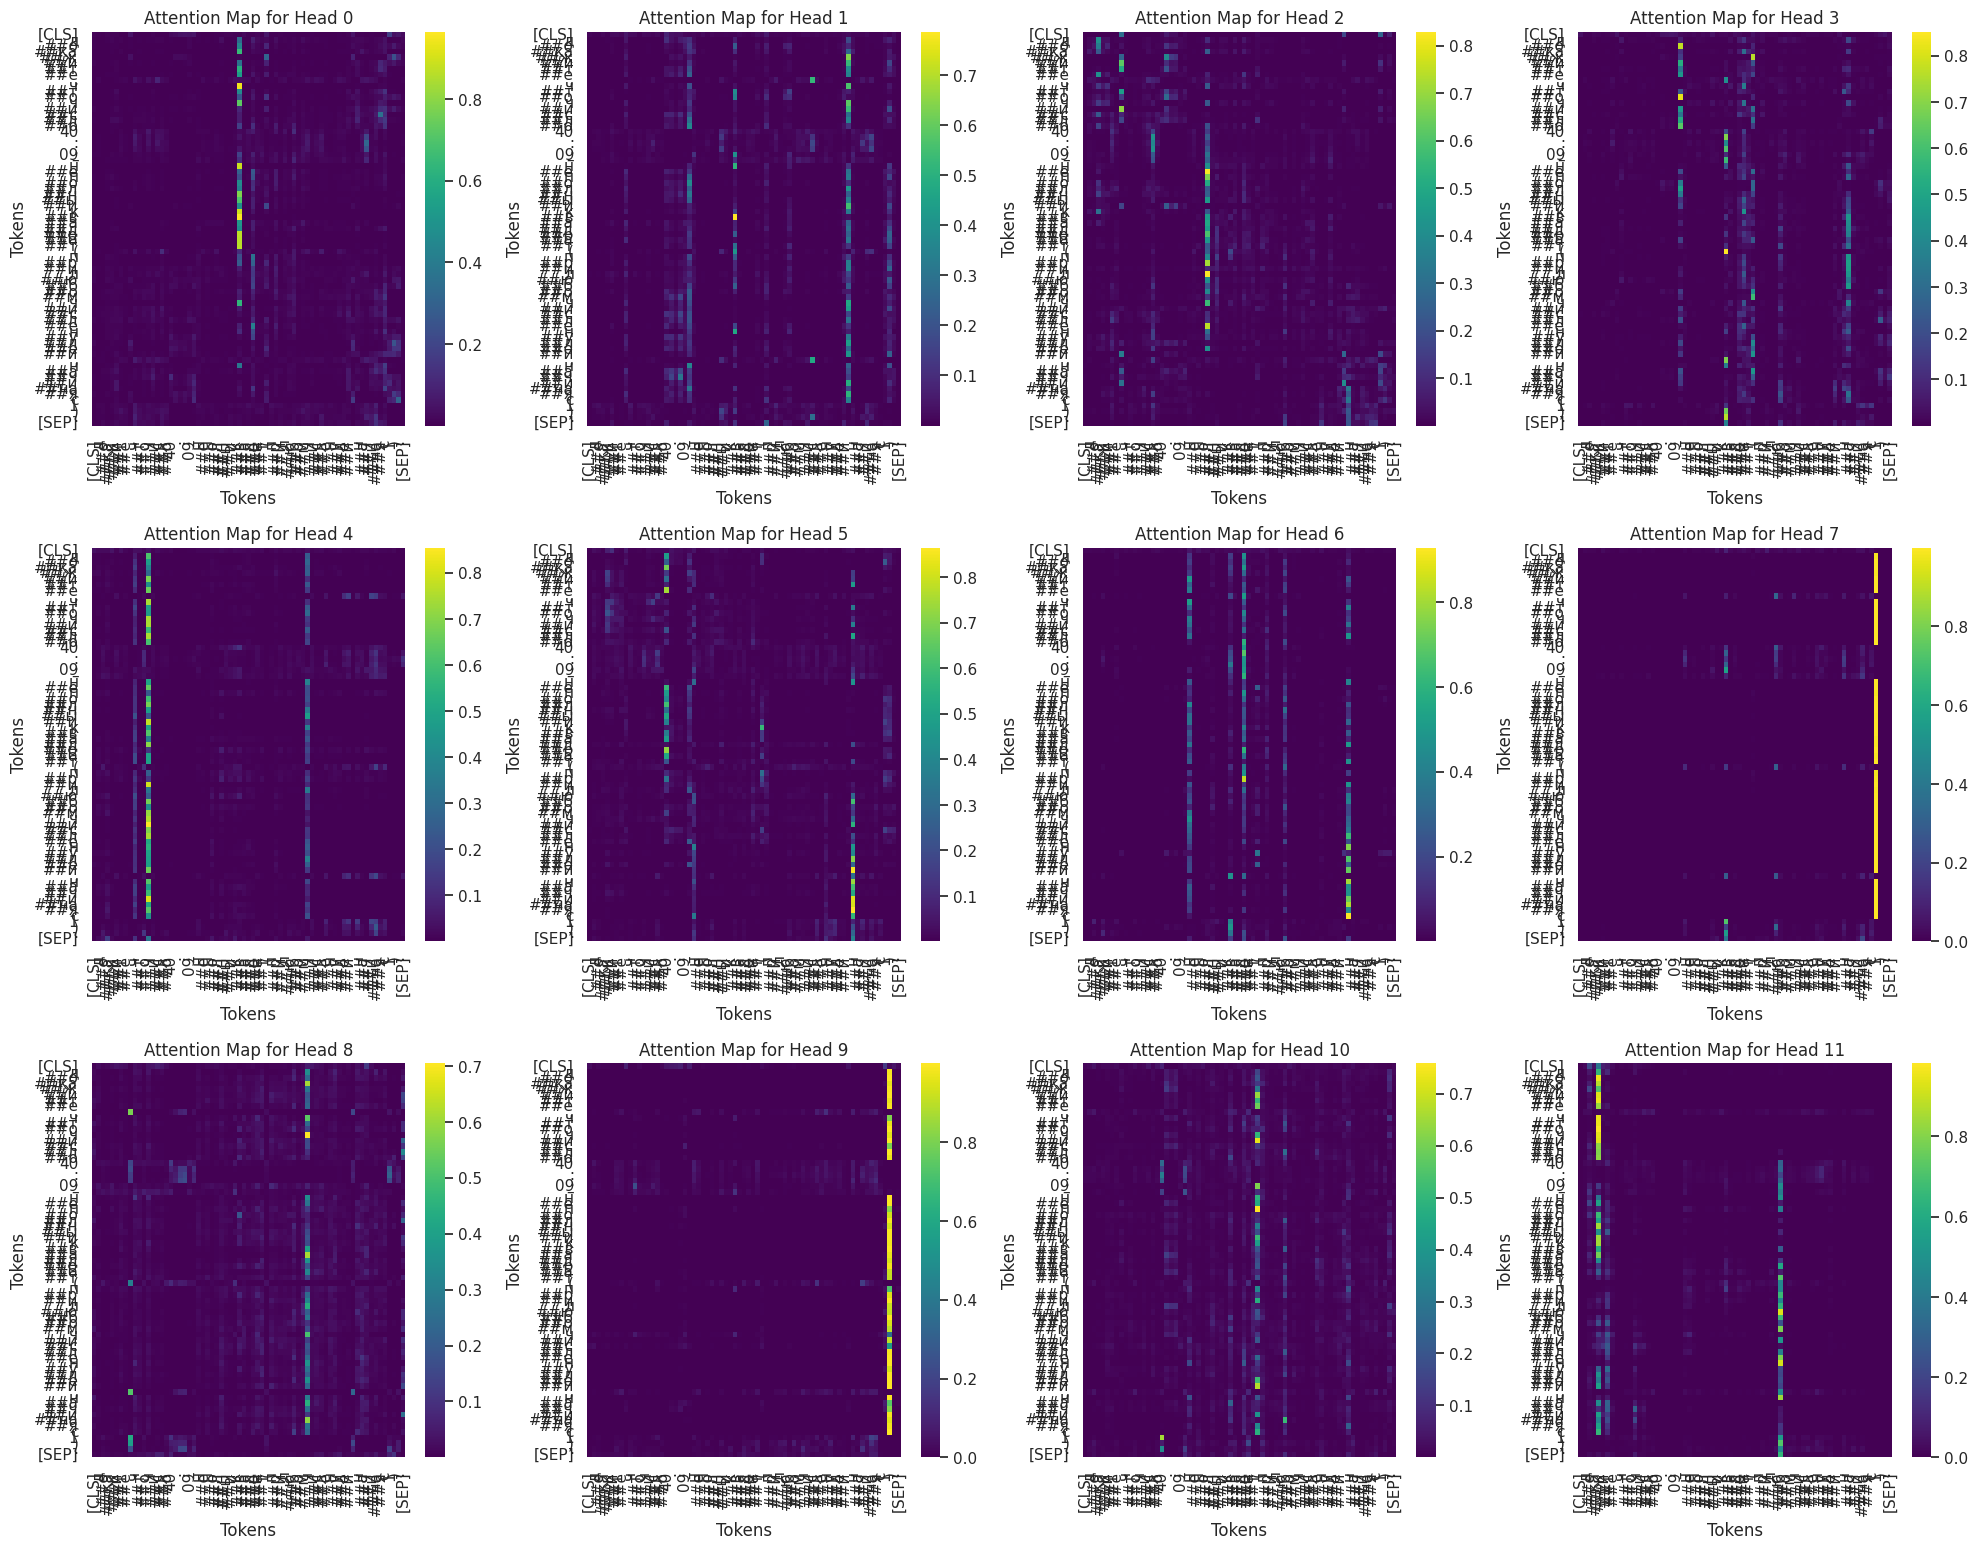

Геометрия        0
Графы            0
Дирихле          0
Инвариант        0
Комбинаторика    0
Многочлен        0
Теория чисел     1
Name: 4172, dtype: int64


In [24]:
names = ["cointegrated/rubert-tiny2", "tbs17/MathBERT"]
for name in names:
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = TransformerClassificationModel(name, n_classes = 7)
    model_finetuned = train_transformer(model,
                                            train_dataloader=train_loader,
                                            val_dataloader=val_loader,
                                            num_epochs=5, freeze_backbone=False, draw=False)
    sample_text = X_test.iloc[256]
    sample_label = y_test.iloc[256]
        
    attention_head_ids = list(range(12))
    draw_first_layer_attention_maps(attention_head_ids, tokenizer, sample_text, model_finetuned)
    print(sample_label)

конечно изменились, ведь мы дообучали все слои.